In [1]:
import time
import warnings
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import pandas as pd
import polars as pl
pl.enable_string_cache(True)

warnings.filterwarnings('ignore')

from feature_engine.encoding import OrdinalEncoder
from feature_engine.creation import CyclicalFeatures
# from feature_engine.selection import DropFeatures
# from feature_engine.creation import MathFeatures

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

seed=42

    Unfortunately, using the whole dataset for training results in running out of memory too early. 

    Hence, for every district, those GEOHASHs with top 20 mean traffic density will be chosen. This way, we get data points from all districts in Istanbul and most importantly, reduce the amount of data to train.

    As seen from the image below, those GEOHASH represented in red are chosen and the ones in yellow are filtered out.

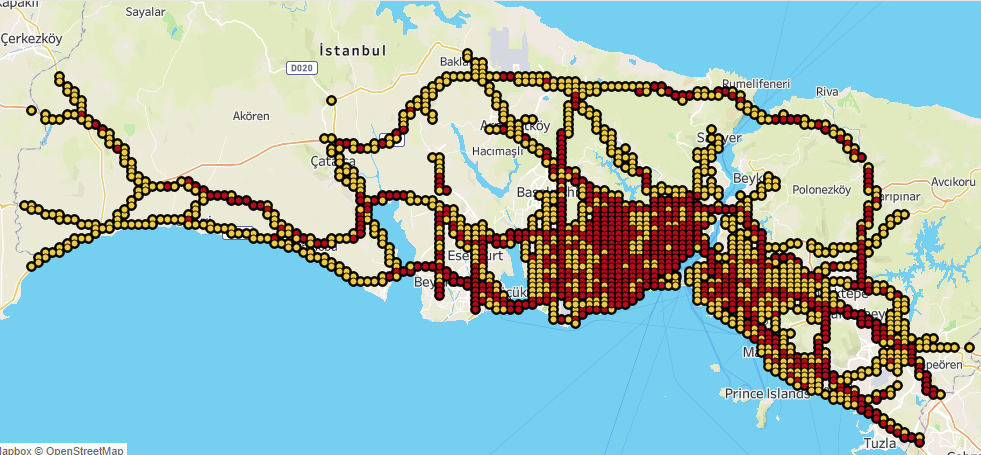

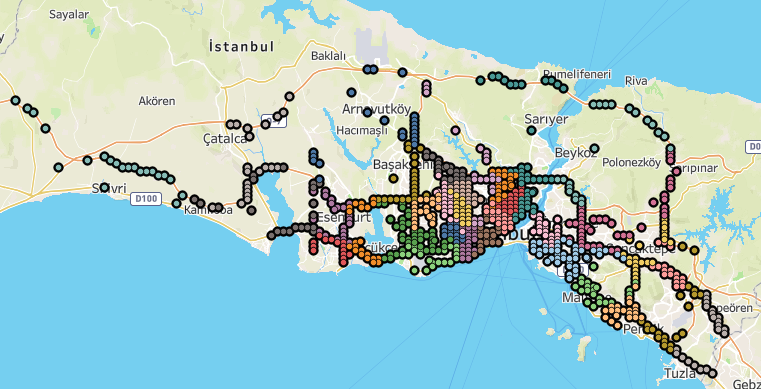

In [2]:
top_TD_GH_by_district = np.array(
    pl.scan_parquet("../datasets/19_model/train.zstd")
    .groupby(['DISTRICT', 'GEOHASH'])
    .agg(pl.col(['NUMBER_OF_VEHICLES']).mean())
    .sort(['DISTRICT', 'NUMBER_OF_VEHICLES'], descending=True)
    .with_columns(pl.col('NUMBER_OF_VEHICLES').rank('dense', descending=True).over('DISTRICT').alias('TD_row'))
    .filter(pl.col('TD_row').le(20))
    .select('GEOHASH')
    .collect(streaming=True)\
        ['GEOHASH']
    .to_list()
    # .to_pandas()
    # .to_excel("datasets/18_Viz/top_10_td_gh_district.xlsx", index=False)
)

len(top_TD_GH_by_district)

720

In [3]:
stadium_df = (
    pl.read_csv("../datasets/13_gh_proximities/gh_nearby_stadiums.csv")
    .filter(pl.col('type').eq('geohash'))
    .select(pl.col('name').cast(pl.Categorical).alias('GEOHASH'))
    .with_columns(pl.lit(1).alias('IS_NEARBY_STADIUM'))
)

stadium_df.head()

GEOHASH,IS_NEARBY_STADIUM
cat,i32
"""sxk3zw""",1
"""sxk3zt""",1
"""sxk3zx""",1
"""sxk97m""",1
"""sxk97q""",1


In [4]:
# Train set
X_train = (
    pl.read_parquet("../datasets/19_model/train.zstd")
    .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
    .drop('NUMBER_OF_VEHICLES', 'TD_LAG1')
    .join(stadium_df, on='GEOHASH', how='left')
    .with_columns(pl.col('IS_NEARBY_STADIUM').fill_null(0).cast(pl.Boolean))
    .to_pandas()
    .set_index('DATE_TIME')
)

y_train = (
    pl.read_parquet("../datasets/19_model/train.zstd")
    .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
    .select(['DATE_TIME', 'NUMBER_OF_VEHICLES'])
    .to_pandas()
    .set_index('DATE_TIME')
)

# Validation set
X_valid = (
    pl.read_parquet("../datasets/19_model/valid.zstd")
    .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
    .drop('NUMBER_OF_VEHICLES', 'TD_LAG1')
    .join(stadium_df, on='GEOHASH', how='left')
    .with_columns(pl.col('IS_NEARBY_STADIUM').fill_null(0).cast(pl.Boolean))
    .to_pandas()
    .set_index('DATE_TIME')
)

y_valid = (
    pl.read_parquet("../datasets/19_model/valid.zstd")
    .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
    .select(['DATE_TIME', 'NUMBER_OF_VEHICLES'])
    .to_pandas()
    .set_index('DATE_TIME')
)

X_train.head()

,GEOHASH,DISTRICT,LOCATION_TYPE,CITIZEN_RETURN,CITIZEN_ARRIVAL,TOURIST_ARRIVAL,HOLIDAY_NAME,HOLIDAY_TYPE,SCHOOL_HOLIDAY_TYPE,HIGHWAY_TRNSPRT_PSNGRS,...,RAIN,SNOW,RAIN_LAG1,SNOW_LAG1,YEAR,MONTH,DAY,HOUR,DAYOFWEEK,IS_NEARBY_STADIUM
DATE_TIME,,,,,,,,,,,,,,,,,,,,,
2020-01-01,sxk90n,Bahçelievler,avenue,627933,692729,1017034,New Year's Day,National holiday,Christmas holidays,15430,...,0.0,0.0,0.0,0.0,2020,1,1,0,3,False
2020-01-01,sxk3pn,Küçükçekmece,avenue,627933,692729,1017034,New Year's Day,National holiday,Christmas holidays,15430,...,0.0,0.0,0.0,0.0,2020,1,1,0,3,False
2020-01-01,sxkcd0,Çekmeköy,street,627933,692729,1017034,New Year's Day,National holiday,Christmas holidays,15430,...,0.0,0.0,0.0,0.0,2020,1,1,0,3,False
2020-01-01,sxk97t,Beyoğlu,other,627933,692729,1017034,New Year's Day,National holiday,Christmas holidays,15430,...,0.0,0.0,0.0,0.0,2020,1,1,0,3,False
2020-01-01,sxk3w7,Başakşehir,street,627933,692729,1017034,New Year's Day,National holiday,Christmas holidays,15430,...,0.0,0.0,0.0,0.0,2020,1,1,0,3,False


In [5]:
y_train.head()

,NUMBER_OF_VEHICLES
DATE_TIME,
2020-01-01,192
2020-01-01,185
2020-01-01,32
2020-01-01,40
2020-01-01,122


In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14705280 entries, 2020-01-01 00:00:00 to 2022-04-30 23:00:00
Data columns (total 35 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   GEOHASH                     category
 1   DISTRICT                    category
 2   LOCATION_TYPE               category
 3   CITIZEN_RETURN              uint32  
 4   CITIZEN_ARRIVAL             uint32  
 5   TOURIST_ARRIVAL             uint32  
 6   HOLIDAY_NAME                category
 7   HOLIDAY_TYPE                category
 8   SCHOOL_HOLIDAY_TYPE         category
 9   HIGHWAY_TRNSPRT_PSNGRS      uint32  
 10  SEA_TRNSPRT_PSNGRS          uint32  
 11  RAIL_TRNSPRT_PSNGRS         uint32  
 12  IS_COVID_RESTRICTION        bool    
 13  IS_FOOTBALL_MATCH           bool    
 14  NEARBY_LANDMARKS_CNT        uint8   
 15  NEARBY_PARKING_CAPACITY     uint16  
 16  NEARBY_TAXI_STND_CNT        uint8   
 17  NEARBY_MINIBUS_STOPS_CNT    uint8   
 18  NEARBY_F

In [7]:
X_train.isnull().sum()

GEOHASH                       0
DISTRICT                      0
LOCATION_TYPE                 0
CITIZEN_RETURN                0
CITIZEN_ARRIVAL               0
TOURIST_ARRIVAL               0
HOLIDAY_NAME                  0
HOLIDAY_TYPE                  0
SCHOOL_HOLIDAY_TYPE           0
HIGHWAY_TRNSPRT_PSNGRS        0
SEA_TRNSPRT_PSNGRS            0
RAIL_TRNSPRT_PSNGRS           0
IS_COVID_RESTRICTION          0
IS_FOOTBALL_MATCH             0
NEARBY_LANDMARKS_CNT          0
NEARBY_PARKING_CAPACITY       0
NEARBY_TAXI_STND_CNT          0
NEARBY_MINIBUS_STOPS_CNT      0
NEARBY_FERRIES_CNT            0
NEARBY_METRO_STNS_CNT         0
NEARBY_BUS_STOP_CNT           0
NEARBY_FUEL_STNS_CNT          0
NEARBY_ISBIKE_STANDS_CNT      0
NEARBY_BIKE_MM_PARKING_CNT    0
TEMP                          0
RAIN                          0
SNOW                          0
RAIN_LAG1                     0
SNOW_LAG1                     0
YEAR                          0
MONTH                         0
DAY     

In [8]:
# Unique GEOHASH count
total_gh = len(X_train['GEOHASH'].unique())
total_gh

720

In [9]:
cat_cols = [col for col in X_train.columns if X_train[col].dtype=='category']
time_cols = ['DAY', 'MONTH', 'HOUR', 'DAYOFWEEK'] #excluding year

print('String columns:', cat_cols)
print('Time columns:', time_cols)

# Encode categorical columns with numbers.
ord_encoder=OrdinalEncoder(encoding_method='arbitrary', variables=cat_cols)

# Convert time features such as day, month, hour and day of week to cyclical features to maintain cyclicity.
cf_encoder = CyclicalFeatures(variables=time_cols, drop_original=True)


#Creating encoder pipeline
encoders = make_pipeline(
    (ord_encoder), #Ordinal Encoder
    (cf_encoder), #Cyclical Feature
)

String columns: ['GEOHASH', 'DISTRICT', 'LOCATION_TYPE', 'HOLIDAY_NAME', 'HOLIDAY_TYPE', 'SCHOOL_HOLIDAY_TYPE']
Time columns: ['DAY', 'MONTH', 'HOUR', 'DAYOFWEEK']


In [10]:
# XGBoost
xgb=XGBRegressor(
    n_estimators=100,
    max_depth=6,
    eta=0.1,
    gamma=2,
    n_jobs=-1, 
    random_state=seed,
    eval_metric="rmse"
)

#Putting whole pipeline together
pipeline = make_pipeline(
    (encoders), #Encoders
    (xgb) #XGBoost
)

print("Pipeline Created!")

Pipeline Created!


#### Visualizing how Cross Validation will be carried out

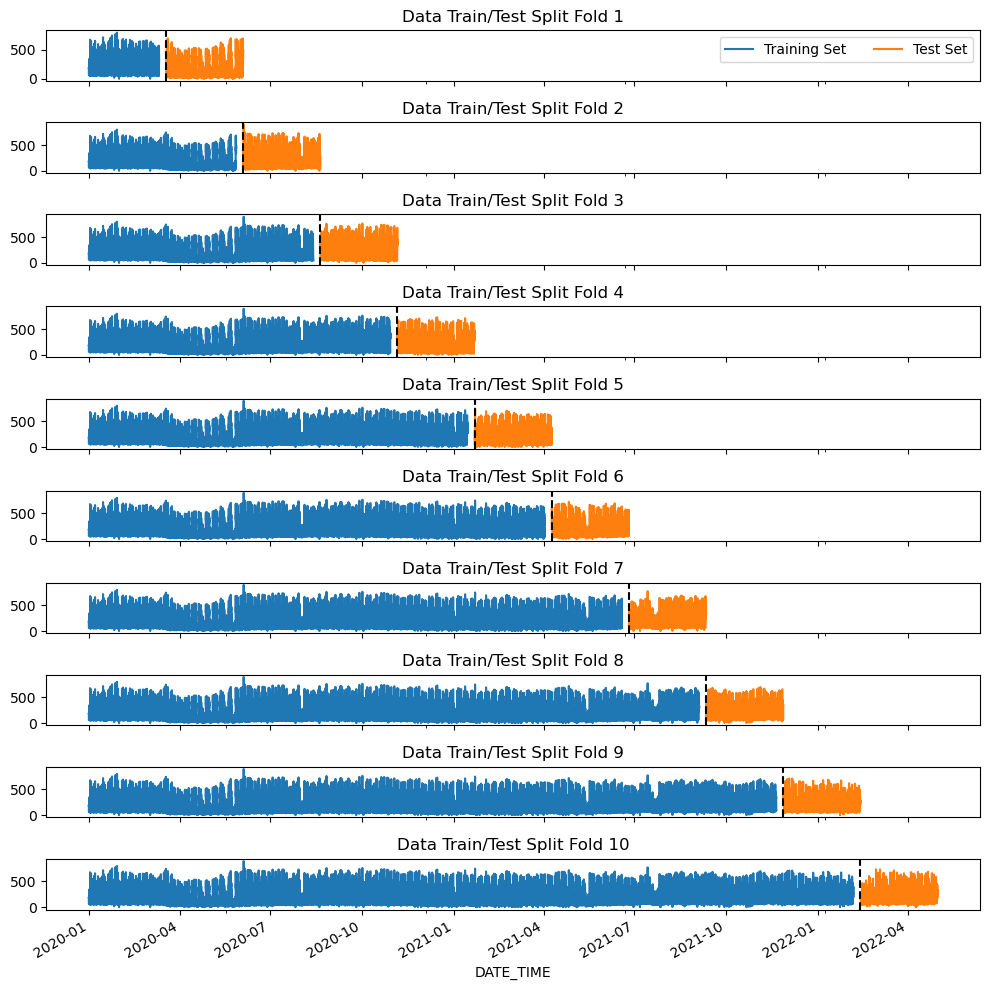

In [11]:
# choosing only a sample of dataset
sample = (
    pd.concat([X_train, y_train], axis=1)
    .query("GEOHASH in ('sxk90n', 'sxk3pn')")
)

N=2
H=24

#Visualizing how the cross validation will be done
n_split = 10

max_train_size=None
test_size=None


# max_train_size=N*H*240
# test_size=N*H*60

sample_tss = TimeSeriesSplit(
    n_splits=n_split, 
    max_train_size=max_train_size, 
    test_size=test_size, 
    gap=N*H*7
)

fig, axs = plt.subplots(n_split, 1, figsize=(10, n_split), sharex=True, tight_layout=True)

fold = 0
for train_idx, val_idx in sample_tss.split(sample):
    train_cv = sample.iloc[train_idx]
    test_cv = sample.iloc[val_idx]
    
    train_cv.plot(y='NUMBER_OF_VEHICLES', ax=axs[fold], label='Training Set',
                  title=f'Data Train/Test Split Fold {fold + 1}', legend=False)
    
    test_cv.plot(y='NUMBER_OF_VEHICLES', ax=axs[fold], label='Test Set', legend=False)
    
    axs[fold].axvline(test_cv.index.min(), color='black', ls='--')
    
    fold += 1

axs.flatten()[0].legend(ncol=2, loc='upper right');

#### Cross Validation

In [12]:
def plot_cv_results(pipeline):
    
    feat_scores=pipeline.steps[-1][-1].feature_importances_
    feat_names=pipeline.steps[-1][-1].feature_names_in_

    #Creating a dataframe for feature importance
    feat_imp_df = (
        pd.DataFrame({'features' : feat_names,'importance' : np.abs(np.round(feat_scores, 3))})
        .set_index('features').sort_values('importance')
    )
    
    #Print Features with Low Importance
    print("Features with Low Importance:")
    print(np.sort(feat_imp_df.query("importance<=0.001").index))
    
    #Plot
    ax = feat_imp_df.plot(kind='barh', edgecolor='k', figsize=(3, 20))
    ax.bar_label(ax.containers[0], fontsize=13, padding=3);
    ax.legend().remove()
    ax.set_title("Feature Importance")
    
    plt.show();

In [13]:
def cv_and_validate(cv, pipeline, X_train, y_train, X_valid, y_valid):

    rmse_values = []

    count = 1
    # Loop through the folds
    print("Cross Validating.....")
    print()
    
    # start timer
    loop_time = time.time()

    for train_index, test_index in cv.split(X_train, y_train):

        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # Fit the model on the train data
        pipeline.fit(X_train_cv, y_train_cv)

        # Predict on the test data
        y_pred = np.round(pipeline.predict(X_test_cv))

        # Calculate the mean squared error
        rmse = mean_squared_error(y_test_cv, y_pred, squared=False)

        print(f"cv #{count}: RMSE = {rmse:.3f} | Time taken: {(time.time() - loop_time)/60:.2f} min")

        rmse_values.append(rmse)
        count += 1
        loop_time = time.time()
        
    # Print the average MSE over all folds
    print()
    print(f"Average Train RMSE: {np.mean(rmse_values):.3f} ± {np.std(rmse_values):.2f}")


    #Predicting on Validation set
    predictions = pipeline.predict(X_valid)
    test_rmse = mean_squared_error(y_valid, predictions, squared=False)

    print(f"Test RMSE Score: {test_rmse:.3f}")
    print()

    # Plot Feature importance
    plot_cv_results(pipeline=pipeline)

    # return the trained model and predictions
    return pipeline, predictions

Cross Validating.....

cv #1: RMSE = 83.240 | Time taken: 2.10 min
cv #2: RMSE = 64.371 | Time taken: 4.40 min
cv #3: RMSE = 63.426 | Time taken: 7.27 min
cv #4: RMSE = 61.449 | Time taken: 2.13 min
cv #5: RMSE = 59.936 | Time taken: 2.94 min
cv #6: RMSE = 59.250 | Time taken: 3.14 min
cv #7: RMSE = 65.555 | Time taken: 4.12 min
cv #8: RMSE = 65.369 | Time taken: 5.48 min
cv #9: RMSE = 61.169 | Time taken: 6.72 min
cv #10: RMSE = 66.892 | Time taken: 8.42 min

Average Train RMSE: 65.066 ± 6.52
Test RMSE Score: 61.210

Features with Low Importance:
['IS_FOOTBALL_MATCH' 'RAIN' 'SNOW']


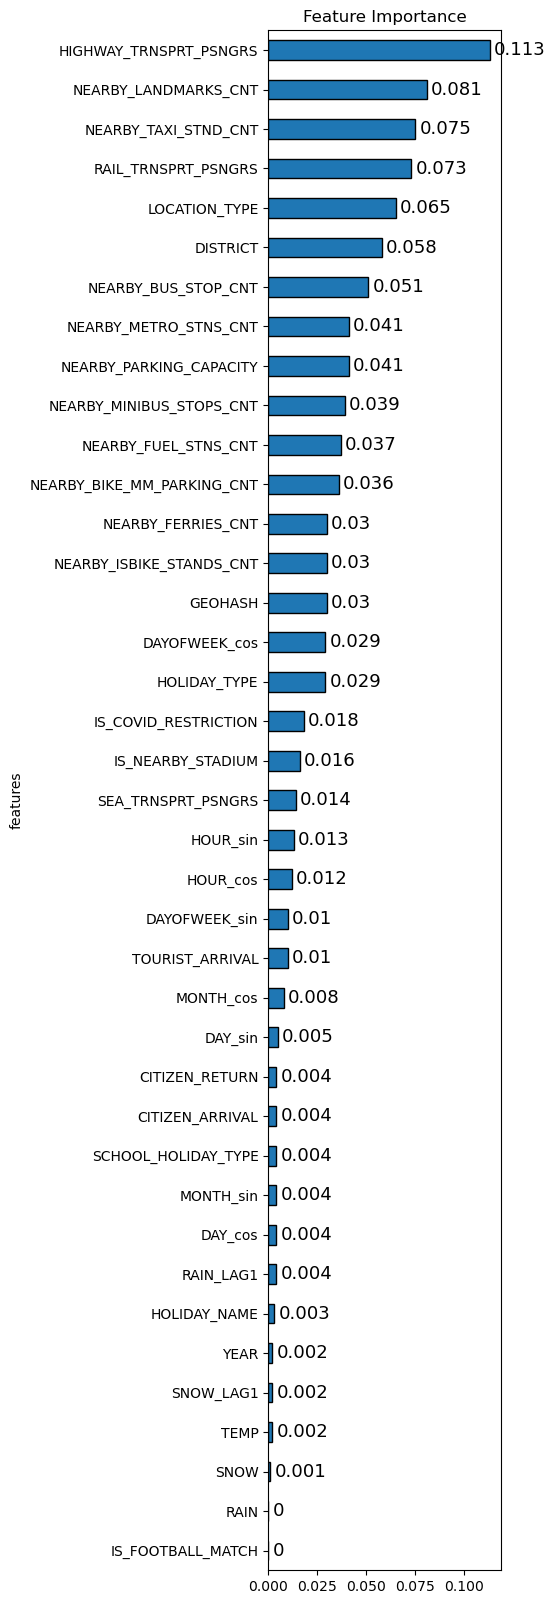

Wall time: 47min 35s


In [14]:
%%time

N=total_gh # number of unique GEOHASH
H=24 # 24 hours
n_split=10 # 10 fold CV

max_train_size = None
test_size = None

# max_train_size=N*H*396 # set the training window size as 396 days
# test_size=N*H*45 # set test window size as 45 days

tss = TimeSeriesSplit(
    n_splits=n_split, 
    max_train_size=max_train_size, 
    test_size=test_size, 
    gap=N*H*7 # leave a gap of 7 days
)

trained_model, predicted_td = cv_and_validate(cv=tss, 
                               pipeline=pipeline,  
                               X_train=X_train,
                               y_train=y_train,
                               X_valid=X_valid,
                               y_valid=y_valid)

In [15]:
val_pred_df = (
    pd.concat([X_valid[['GEOHASH', 'DISTRICT']], y_valid], axis=1)
    .assign(td_pred=predicted_td)
)

val_pred_df.head()

,GEOHASH,DISTRICT,NUMBER_OF_VEHICLES,td_pred
DATE_TIME,,,,
2022-05-01,sxk90n,Bahçelievler,252,244.532120
2022-05-01,sxk3pn,Küçükçekmece,230,192.610947
2022-05-01,sxkcd0,Çekmeköy,67,120.093811
2022-05-01,sxk97t,Beyoğlu,52,65.136673
2022-05-01,sxk3w7,Başakşehir,123,158.201569


In [16]:
len(val_pred_df['GEOHASH'].unique())

720

In [17]:
(
    val_pred_df.groupby('GEOHASH')
    .agg({"NUMBER_OF_VEHICLES" : "mean"})
    .dropna()
    .nlargest(1, 'NUMBER_OF_VEHICLES')
)

,NUMBER_OF_VEHICLES
GEOHASH,
sxk3xe,500.625871


In [18]:
(
    val_pred_df.groupby('GEOHASH')
    .agg({"NUMBER_OF_VEHICLES" : "mean"})
    .dropna()
    .nsmallest(1, 'NUMBER_OF_VEHICLES')
)

,NUMBER_OF_VEHICLES
GEOHASH,
sxk35q,7.493159


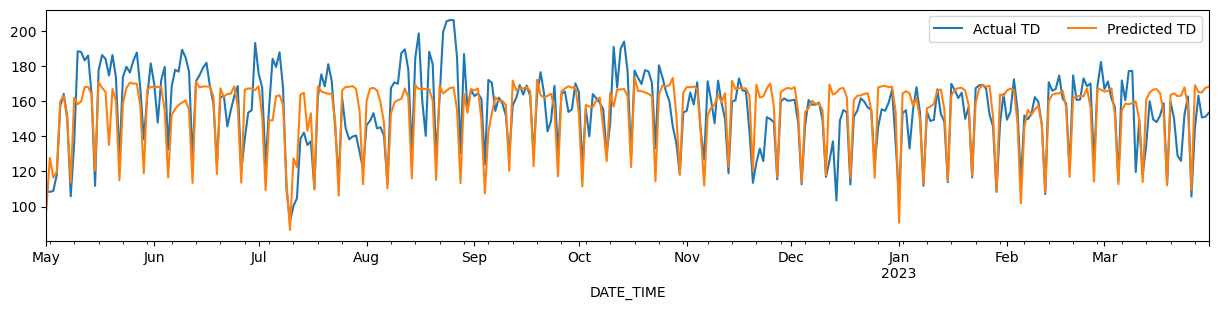

In [19]:
ax = (
    val_pred_df
    .resample('D')[['NUMBER_OF_VEHICLES', 'td_pred']].mean()
    .plot(figsize=(15, 3))
)

ax.legend(labels=["Actual TD", "Predicted TD"], ncol=2, loc="upper right");

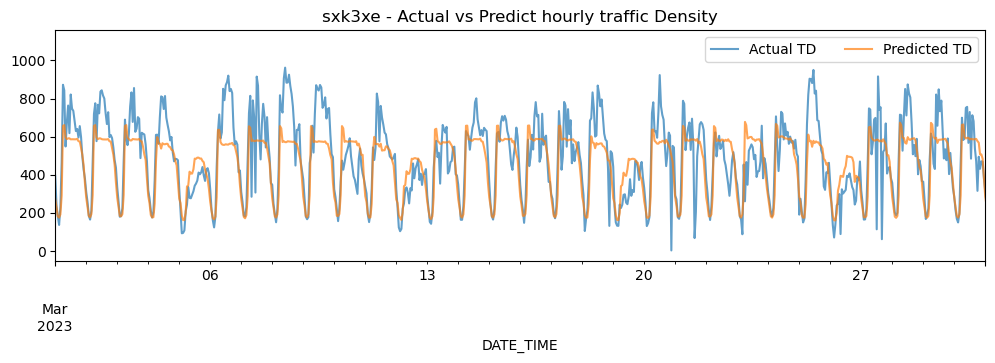

In [20]:
gh='sxk3xe'

ax = (
    val_pred_df.query(f"GEOHASH=='{gh}'")
    .plot(y=['NUMBER_OF_VEHICLES', 'td_pred'], figsize=(12, 3), alpha=0.7)
)

ax.set_title(f"{gh} - Actual vs Predict hourly traffic Density")
ax.legend(labels=["Actual TD", "Predicted TD"], ncol=2, loc="upper right");
ax.set_xlim("2023-03-01", "2023-03-31");

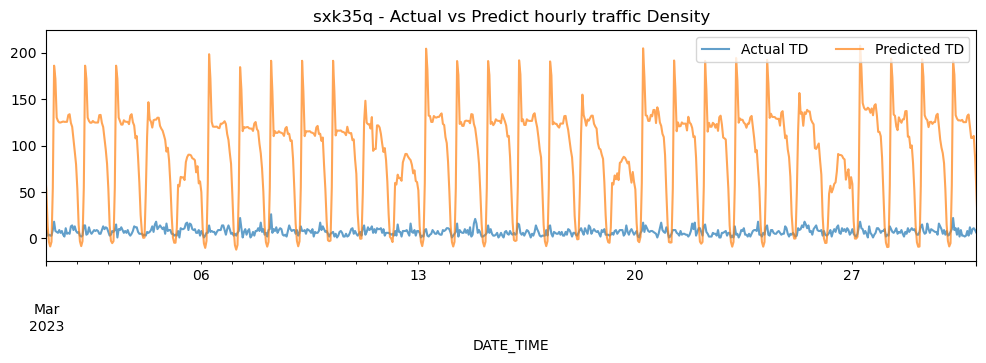

In [21]:
gh='sxk35q'

ax = (
    val_pred_df.query(f"GEOHASH=='{gh}'")
    .plot(y=['NUMBER_OF_VEHICLES', 'td_pred'], figsize=(12, 3), alpha=0.7)
)

ax.set_title(f"{gh} - Actual vs Predict hourly traffic Density")
ax.legend(labels=["Actual TD", "Predicted TD"], ncol=2, loc="upper right");
ax.set_xlim("2023-03-01", "2023-03-31");